<a href="https://colab.research.google.com/github/PandukaBandara99/ML-Books/blob/main/AdvancedTensorFlow2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mahela Panduka Bandara ; <br> UG @ Dpt. of Electronic & Electrical Engineering ;<br> University of Peradeniya ;<br> 2024/05 <br><br> Email : e19039@end.pdn.ac.lk <br> LinkedIN : https://www.linkedin.com/in/pandukabandara/

Refferences: <br>
1 - https://www.coursera.org/specializations/tensorflow-advanced-techniques

## From the Previous Note#

### Custom Callbacks

#### Introduction

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import datetime
import io

from PIL import Image
from IPython.display import Image as IPyImage
import imageio

print("Version: ", tf.__version__)
tf.get_logger().setLevel('INFO')

Version:  2.15.0


In [ ]:
# Define the Keras model to add callbacks to
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1, activation = 'linear', input_dim = 784))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.1), loss='mean_squared_error', metrics=['mae'])
    return model

In [ ]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

11490434/11490434 [==============================] - 0s 0us/step


Now, define a simple custom callback to track the start and end of every batch of data. During those calls, it prints the index of the current batch.

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_train_batch_begin(self, batch, logs=None):
        print('Training: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

    def on_train_batch_end(self, batch, logs=None):
        print('Training: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

Providing a callback to model methods such as tf.keras.Model.fit() ensures the methods are called at those stages:



In [ ]:
model = get_model()
_ = model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          steps_per_epoch=5,
          verbose=0,
          callbacks=[MyCustomCallback()])

Training: batch 0 begins at 05:06:53.631340
Training: batch 0 ends at 05:06:55.872047
Training: batch 1 begins at 05:06:55.872983
Training: batch 1 ends at 05:06:55.878866
Training: batch 2 begins at 05:06:55.880221
Training: batch 2 ends at 05:06:55.891222
Training: batch 3 begins at 05:06:55.893292
Training: batch 3 ends at 05:06:55.897315
Training: batch 4 begins at 05:06:55.898569
Training: batch 4 ends at 05:06:55.901915


**An overview of callback methods**
Common methods for training/testing/predicting
> For training, testing, and predicting, following methods are provided to be overridden.

`on_(train|test|predict)_begin(self, logs=None)` <br>

> Called at the beginning of `fit/evaluate/predict.`

`on_(train|test|predict)_end(self, logs=None)` <br>

> Called at the end of `fit/evaluate/predict.`

`on_(train|test|predict)_batch_begin(self, batch, logs=None)` <br>

> Called right before processing a batch during training/testing/predicting. Within this method, logs is a dict with batch and size available keys, representing the current batch number and the size of the batch.

`on_(train|test|predict)_batch_end(self, batch, logs=None)`<br>

> Called at the end of training/testing/predicting a batch. Within this method, logs is a dict containing the stateful metrics result.

**Training specific methods**
In addition, for training, following are provided.

`on_epoch_begin(self, epoch, logs=None)`

> Called at the beginning of an epoch during training.

`on_epoch_end(self, epoch, logs=None)`
> Called at the end of an epoch during training.

#### Usage of `logs dict`


The logs dict contains the loss value, and all the metrics at the end of a batch or epoch. Example includes the loss and mean absolute error.

In [ ]:
callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch,logs:
    print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))
)

model = get_model()
_ = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=64,
          epochs=3,
          verbose=0,
          callbacks=[callback])

Epoch: 0, Val/Train loss ratio: 0.72
Epoch: 1, Val/Train loss ratio: 0.91
Epoch: 2, Val/Train loss ratio: 0.94


In [ ]:
class DetectOverfittingCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.7):
        super(DetectOverfittingCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        ratio = logs["val_loss"] / logs["loss"]
        print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, ratio))

        if ratio > self.threshold:
            print("Stopping training...")
            self.model.stop_training = True

model = get_model()
_ = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=64,
              epochs=3,
              verbose=0,
              callbacks=[DetectOverfittingCallback()])

Epoch: 0, Val/Train loss ratio: 0.73
Stopping training...


Similarly, one can provide callbacks in `evaluate()` calls.



#### Custom callback to Visualize predictions

In [ ]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [ ]:
# Visualization utilities
plt.rc('font', size=20)
plt.rc('figure', figsize=(15, 3))

def display_digits(inputs, outputs, ground_truth, epoch, n=10):
    plt.clf()

    plt.yticks([])
    plt.grid(None)
    inputs = np.reshape(inputs, [n, 28, 28])
    inputs = np.swapaxes(inputs, 0, 1)
    inputs = np.reshape(inputs, [28, 28*n])
    plt.imshow(inputs)
    plt.xticks([28*x+14 for x in range(n)], outputs)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if outputs[i] == ground_truth[i]:
            t.set_color('green')
        else:
            t.set_color('red')
    plt.grid(None)

In [ ]:
GIF_PATH = './animation.gif'

In [ ]:
class VisCallback(tf.keras.callbacks.Callback):
    def __init__(self, inputs, ground_truth, display_freq=10, n_samples=10):
        self.inputs = inputs
        self.ground_truth = ground_truth
        self.images = []
        self.display_freq = display_freq
        self.n_samples = n_samples

    def on_epoch_end(self, epoch, logs=None):
        # Randomly sample data
        indexes = np.random.choice(len(self.inputs), size=self.n_samples)
        X_test, y_test = self.inputs[indexes], self.ground_truth[indexes]
        predictions = np.argmax(self.model.predict(X_test), axis=1)

        # Plot the digits
        display_digits(X_test, predictions, y_test, epoch, n=self.n_samples)

        # Save the figure
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = Image.open(buf)
        self.images.append(np.array(image))

        # Display the digits every 'display_freq' number of epochs
        if epoch % self.display_freq == 0:
            plt.show()

    def on_train_end(self, logs=None):
        imageio.mimsave(GIF_PATH, self.images, fps=1)

In [ ]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='linear', input_dim=784))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

1/1 [==============================] - 0s 82ms/step


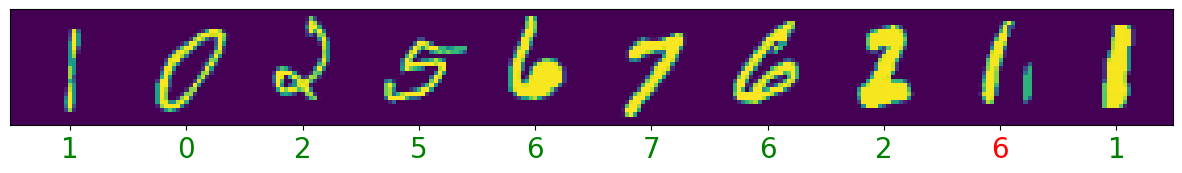

1/1 [==============================] - 0s 37ms/step


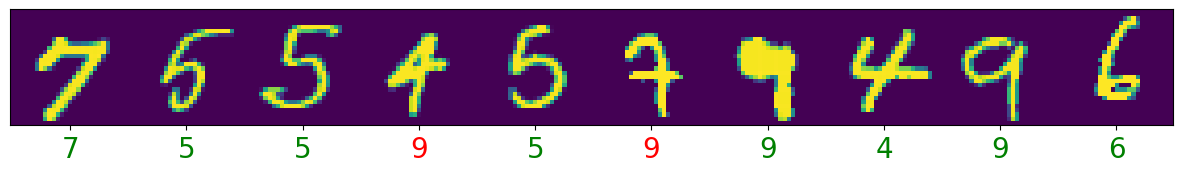

1/1 [==============================] - 0s 21ms/step


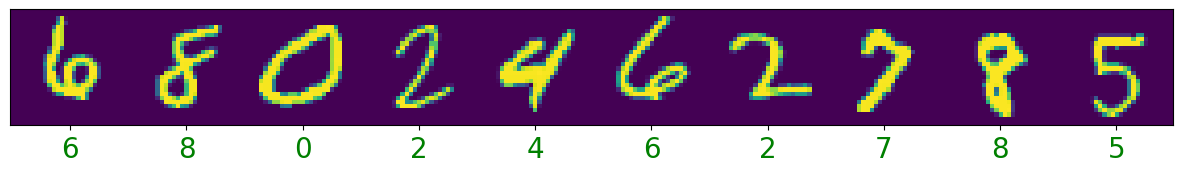

In [ ]:
model = get_model()
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=0,
          callbacks=[VisCallback(x_test, y_test)])

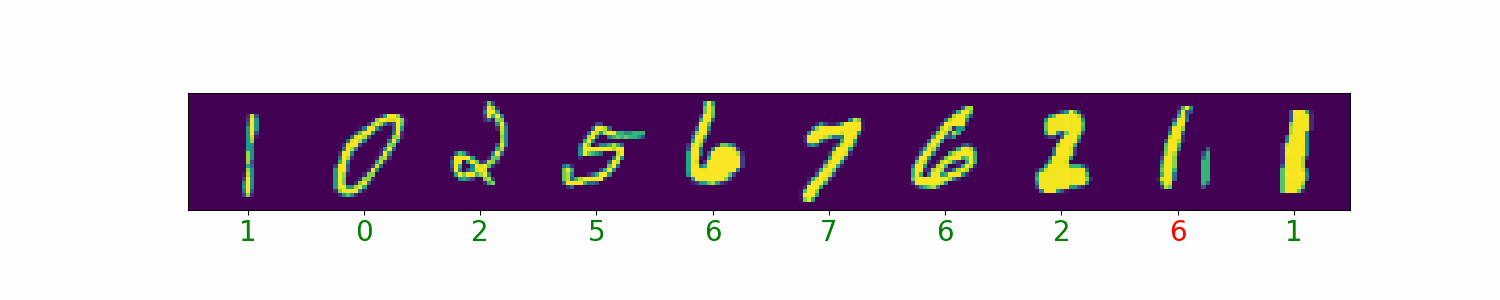

In [ ]:
SCALE = 60

# FYI, the format is set to PNG here to bypass checks for acceptable embeddings
IPyImage(GIF_PATH, format='png', width=15 * SCALE, height=3 * SCALE)

# 2.0 Custom and Distributed Training with TensorFlow

## 2.1 Tensors

In [ ]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import numpy as np

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### Basic Tensor operations

Create a single dimension numpy array on which you can perform some operation. You'll make an array of size 25, holding values from 0 to 24.

In [ ]:
# Create a 1D uint8 NumPy array comprising of first 25 natural numbers
x = np.arange(0, 25)
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

To change that array into a tensor,

In [ ]:
# Convert NumPy array to Tensor using `tf.constant`
x = tf.constant(x)
x

<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])>

Now the tensor operations can be applied. As an example apply square (element-wise) all the values in the tensor x

In [ ]:
# Square the input tensor x
x = tf.square(x)
x

<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576])>

### Tensor Reshape

One feature of tensors is that they can be reshaped. When reshpaing, make sure to consider then dimensions that will include all of the values of the tensor.

In [ ]:
# Reshape tensor x into a 5 x 5 matrix.
x = tf.reshape(x, (5, 5))
x

<tf.Tensor: shape=(5, 5), dtype=int64, numpy=
array([[  0,   1,   4,   9,  16],
       [ 25,  36,  49,  64,  81],
       [100, 121, 144, 169, 196],
       [225, 256, 289, 324, 361],
       [400, 441, 484, 529, 576]])>

In [ ]:
# Cast tensor x into float32. Notice the change in the dtype.
x = tf.cast(x, tf.float32)
x

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[  0.,   1.,   4.,   9.,  16.],
       [ 25.,  36.,  49.,  64.,  81.],
       [100., 121., 144., 169., 196.],
       [225., 256., 289., 324., 361.],
       [400., 441., 484., 529., 576.]], dtype=float32)>

When using tf.constant(), you can pass in a 1D array (a vector) and set the shape parameter to turn this vector into a multi-dimensional array.

In [ ]:
tf.constant([1,2,3,4], shape=(2,2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 2],
       [3, 4]], dtype=int32)>

**However, that for tf.Variable()**, the shape of the tensor is derived from the shape given by the input array. Setting shape to something other than None will not reshape a 1D array into a multi-dimensional array, and will give a ValueError.

In [ ]:
try:
    # This will produce a ValueError
    tf.Variable([1,2,3,4], shape=(2,2))
except ValueError as v:
    # See what the ValueError says
    print(v)

In this `tf.Variable` creation, the initial value's shape ((4,)) is not compatible with the explicitly supplied `shape` argument ((2, 2)).


### Broadcasting in Tensors

create a single value float tensor by the help of which will help to see broadcasting in actionC

In [ ]:
# Let's define a constant and see how broadcasting works in the following cell.
y = tf.constant(2, dtype=tf.float32)
y

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

Multiply the tensors x and y together, and notice how multiplication was done and its result.

In [ ]:
# Multiply tensor `x` and `y`. `y` is multiplied to each element of x.
result = tf.multiply(x, y)
result

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[   0.,    2.,    8.,   18.,   32.],
       [  50.,   72.,   98.,  128.,  162.],
       [ 200.,  242.,  288.,  338.,  392.],
       [ 450.,  512.,  578.,  648.,  722.],
       [ 800.,  882.,  968., 1058., 1152.]], dtype=float32)>

Re-Initialize y to a tensor having more values.

In [ ]:
# Now let's define an array that matches the number of row elements in the `x` array.
y = tf.constant([1, 2, 3, 4, 5], dtype=tf.float32)
y

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 2., 3., 4., 5.], dtype=float32)>

In [ ]:
# Let's see first the contents of `x` again.
x  # |=> not affected

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[  0.,   1.,   4.,   9.,  16.],
       [ 25.,  36.,  49.,  64.,  81.],
       [100., 121., 144., 169., 196.],
       [225., 256., 289., 324., 361.],
       [400., 441., 484., 529., 576.]], dtype=float32)>

In [ ]:
# Add tensor `x` and `y`. `y` is added element wise to each row of `x`.
result = x + y
result

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[  1.,   3.,   7.,  13.,  21.],
       [ 26.,  38.,  52.,  68.,  86.],
       [101., 123., 147., 173., 201.],
       [226., 258., 292., 328., 366.],
       [401., 443., 487., 533., 581.]], dtype=float32)>

## 2.2 Gradient Tape

Gradient Tape is a powerful feature in TensorFlow that facilitates automatic differentiation.Gradient Tape is part of TensorFlow's eager execution mode, which allows operations to be evaluated immediately as they are called within Python.

TensorFlow's `tf.GradientTape` records operations for automatic differentiation. Specifically, it records computations made within its context (i.e., between the `GradientTape` `__enter__` and `__exit__` methods) to compute the gradient of some target variables with respect to some source variables.


#### How Gradient Tape Works

1. **Recording Operations:** When you perform operations within the context of a `GradientTape`, TensorFlow records these operations.
2. **Computing Gradients:** Once the operations are recorded, you can use the tape to compute the gradients of a target (typically a loss value) with respect to some source variables (typically model parameters).

To use `tf.GradientTape`:

1. **Define the Model and Loss Function:** You need a model that performs some operations on input data and a loss function to evaluate the performance of the model.
2. **Open a Gradient Tape Context:** Use `with tf.GradientTape() as tape:` to start recording the operations.
3. **Perform Operations within the Context:** Perform the forward pass of the model and compute the loss within the `GradientTape` context.
4. **Compute Gradients:** Use the `tape.gradient(target, sources)` method to compute the gradients of the target with respect to the sources.
5. **Apply Gradients:** Use an optimizer to apply the computed gradients to the model's variables.


#### Example

```python
import tensorflow as tf

# Create a simple model with a single Dense layer
model = tf.keras.Sequential([tf.keras.layers.Dense(1)])

# Define an optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Define a simple mean squared error loss function
loss_fn = tf.keras.losses.MeanSquaredError()

# Input data (e.g., features) and true labels
x = tf.constant([[1.0], [2.0], [3.0], [4.0]])
y_true = tf.constant([[2.0], [4.0], [6.0], [8.0]])

# Training step function
def train_step(x, y_true):
    with tf.GradientTape() as tape:
        # Forward pass: compute predicted y by passing x to the model
        y_pred = model(x, training=True)
        
        # Compute the loss
        loss = loss_fn(y_true, y_pred)
    
    # Compute gradients of the loss with respect to model's variables
    gradients = tape.gradient(loss, model.trainable_variables)
    
    # Apply the gradients to the optimizer
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

# Training loop
for epoch in range(100):
    loss = train_step(x, y_true)
    print(f"Epoch {epoch}, Loss: {loss.numpy()}")
```


#### Important Points

- **Persistent Tapes:** By default, a `tf.GradientTape` is used only once to compute gradients. If you need to compute multiple gradients over the same computation, create a persistent tape by passing `persistent=True` to the `GradientTape` constructor. Remember to delete the tape with `del tape` when done to free resources.
- **Nested Tapes:** You can nest multiple `tf.GradientTape` contexts to compute higher-order derivatives (gradients of gradients).

Example of using a persistent tape:
```python
with tf.GradientTape(persistent=True) as tape:
    # Perform operations
    pass
# Compute gradients multiple times
gradients = tape.gradient(target, sources)
# After usage
del tape
```

#### Use Cases

- **Training Neural Networks:** Calculating gradients of the loss function with respect to model parameters.
- **Custom Training Loops:** Implementing complex training algorithms that require manual gradient calculations.
- **Higher-order Gradients:** Computing gradients of gradients for advanced optimization techniques.



#### Example

In [ ]:
# Define a 2x2 array of 1's
x = tf.ones((2,2))

with tf.GradientTape() as t:
    # Record the actions performed on tensor x with `watch`
    t.watch(x)

    # Define y as the sum of the elements in x
    y =  tf.reduce_sum(x)
    print("y : ",y)

    # Let z be the square of y
    z = tf.square(y)
    print("z : ",z)

# Get the derivative of z wrt the original input tensor x
dz_dx = t.gradient(z, x)

# Print our result
print(dz_dx)

y :  tf.Tensor(4.0, shape=(), dtype=float32)
z :  tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(
[[8. 8.]
 [8. 8.]], shape=(2, 2), dtype=float32)


**Gradient tape expires after one use, by default**

If you want to compute multiple gradients, note that by default, GradientTape is not persistent (`persistent=False`).  This means that the GradientTape will expire after you use it to calculate a gradient.

To see this, set up gradient tape as usual and calculate a gradient, so that the gradient tape will be 'expired'.

In [ ]:
x = tf.constant(3.0)

# Notice that persistent is False by default
with tf.GradientTape() as t:
    t.watch(x)

    # y = x^2
    y = x * x

    # z = y^2
    z = y * y

# Compute dz/dx. 4 * x^3 at x = 3 --> 108.0
dz_dx = t.gradient(z, x)
print(dz_dx)

tf.Tensor(108.0, shape=(), dtype=float32)


In [ ]:
# If you try to compute dy/dx after the gradient tape has expired:
try:
    dy_dx = t.gradient(y, x)  # 6.0
    print(dy_dx)
except RuntimeError as e:
    print("The error message you get is:")
    print(e)

The error message you get is:
A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


##### Make the gradient tape persistent

To make sure that the gradient tape can be used multiple times, set `persistent=True`

In [ ]:
x = tf.constant(3.0)

# Set persistent=True so that you can reuse the tape
with tf.GradientTape(persistent=True) as t:
    t.watch(x)

    # y = x^2
    y = x * x

    # z = y^2
    z = y * y

# Compute dz/dx. 4 * x^3 at x = 3 --> 108.0
dz_dx = t.gradient(z, x)
print(dz_dx)

tf.Tensor(108.0, shape=(), dtype=float32)


In [ ]:
# You can still compute dy/dx because of the persistent flag.
dy_dx = t.gradient(y, x)  # 6.0
print(dy_dx)

Delete the tape variable `t` once you no longer need it.

In [ ]:
# Drop the reference to the tape
del t

### Nested Gradient tapes
To compute a higher order derivative by nesting the `GradientTapes:`

**Acceptable indentation of the first gradient calculation**
Keep in mind that need to make sure that the first gradient calculation of `dy_dx` should occur at least inside the outer `with` block.

In [ ]:
x = tf.Variable(1.0)

with tf.GradientTape() as tape_2:
    with tf.GradientTape() as tape_1:
        y = x * x * x

    # The first gradient calculation should occur at least
    # within the outer with block
    dy_dx = tape_1.gradient(y, x)
d2y_dx2 = tape_2.gradient(dy_dx, x)

print(dy_dx)
print(d2y_dx2)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


The first gradient calculation can also be inside the inner with block.

In [ ]:
x = tf.Variable(1.0)

with tf.GradientTape() as tape_2:
    with tf.GradientTape() as tape_1:
        y = x * x * x

        # The first gradient calculation can also be within the inner with block
        dy_dx = tape_1.gradient(y, x)
d2y_dx2 = tape_2.gradient(dy_dx, x)

print(dy_dx)
print(d2y_dx2)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


**Where not to indent the first gradient calculation**
If the first gradient calculation is OUTSIDE of the outer `with` block, it won't persist for the second gradient calculation.

In [ ]:
x = tf.Variable(1.0)

with tf.GradientTape() as tape_2:
    with tf.GradientTape() as tape_1:
        y = x * x * x

# The first gradient call is outside the outer with block
# so the tape will expire after this
dy_dx = tape_1.gradient(y, x)

# The tape is now expired and the gradient output will be `None`
d2y_dx2 = tape_2.gradient(dy_dx, x)

print(dy_dx)
print(d2y_dx2)

tf.Tensor(3.0, shape=(), dtype=float32)
None


Notice how the `d2y_dx2` calculation is now `None`.  The tape has expired.  Also note that this still won't work even if you set persistent=True for both gradient tapes.

In [ ]:
x = tf.Variable(1.0)

# Setting persistent=True still won't work
with tf.GradientTape(persistent=True) as tape_2:
    # Setting persistent=True still won't work
    with tf.GradientTape(persistent=True) as tape_1:
        y = x * x * x

# The first gradient call is outside the outer with block
# so the tape will expire after this
dy_dx = tape_1.gradient(y, x)

# the output will be `None`
d2y_dx2 = tape_2.gradient(dy_dx, x)

print(dy_dx)
print(d2y_dx2)

tf.Tensor(3.0, shape=(), dtype=float32)
None


 **Proper indentation for the second gradient calculation**

The second gradient calculation `d2y_dx2` can be indented as much as the first calculation of `dy_dx` but not more.

In [ ]:
x = tf.Variable(1.0)

with tf.GradientTape() as tape_2:
    with tf.GradientTape() as tape_1:
        y = x * x * x

        dy_dx = tape_1.gradient(y, x)

        # this is acceptable
        d2y_dx2 = tape_2.gradient(dy_dx, x)

print(dy_dx)
print(d2y_dx2)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


Tis is also acceptable,

In [ ]:
x = tf.Variable(1.0)

with tf.GradientTape() as tape_2:
    with tf.GradientTape() as tape_1:
        y = x * x * x

        dy_dx = tape_1.gradient(y, x)

    # this is also acceptable
    d2y_dx2 = tape_2.gradient(dy_dx, x)

print(dy_dx)
print(d2y_dx2)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


or

In [ ]:
x = tf.Variable(1.0)

with tf.GradientTape() as tape_2:
    with tf.GradientTape() as tape_1:
        y = x * x * x

        dy_dx = tape_1.gradient(y, x)

# this is also acceptable
d2y_dx2 = tape_2.gradient(dy_dx, x)

print(dy_dx)
print(d2y_dx2)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


## 2.3 Custom Training Loops

Steps to training network,
1. Define the network
2. Prepare the training data
3. Define loss and optimizer
4. Train the model on training inputs by minimizing loss using custom optimizer.
5. Validate the model.


#### Define the network

Define your model as a class.
- `x` is the input tensor.
- The model should output values of **wx+b**.
- Start off by initializing w and b to random values.
- During the training process, values of w and b get updated in accordance with linear regression so as to minimize the loss incurred by the model.
- Once arrive at optimal values for w and b, the model would have been trained to correctly predict the values of wx+b.

Hence,
- **w** and **b** are trainable weights of the model.
- **x** is the input
- **y** = wx + b is the output

In [ ]:
class Model(object):
  def __init__(self):
    # Initialize the weights to `2.0` and the bias to `1.0`
    # In practice, these should be initialized to random values (for example, with `tf.random.normal`)
    self.w = tf.Variable(2.0)
    self.b = tf.Variable(1.0)

  def __call__(self, x):
    return self.w * x + self.b

model = Model()

#### Define a loss function



A loss function measures how well the output of a model for a given input matches the target output.
- The goal is to minimize this difference during training.
- Use the standard L2 loss, also known as the least square errors
$$Loss = \sum_{i} \left (y_{pred}^i - y_{target}^i \right )^2$$

In [ ]:
def loss(predicted_y, target_y):
  return tf.reduce_mean(tf.square(predicted_y - target_y))

#### Obtain training data



First, synthesize the training data using the "true" w and "true" b.

$$y = w_{true} \times x + b_{true} $$

In [ ]:
TRUE_w = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

xs  = tf.random.normal(shape=[NUM_EXAMPLES])

ys = (TRUE_w * xs) + TRUE_b

#### Define a training loop


With the network and training data, train the model using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)
- Gradient descent updates the trainable weights **w** and **b** to reduce the loss.


There are many variants of the gradient descent scheme that are captured in `tf.train.Optimizer`.
- Use `tf.GradientTape` for automatic differentiation
- Use `tf.assign_sub` for decrementing a value.  Note that assign_sub combines `tf.assign` and `tf.sub`

In [ ]:
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
  dw, db = t.gradient(current_loss, [model.w, model.b])
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

  return current_loss

Finally, iteratively run through the training data and see how `w` and `b` evolve.

In [ ]:
model = Model()

# Collect the history of W-values and b-values to plot later
list_w, list_b = [], []
epochs = range(15)
losses = []
for epoch in epochs:
  list_w.append(model.w.numpy())
  list_b.append(model.b.numpy())
  current_loss = train(model, xs, ys, learning_rate=0.1)
  losses.append(current_loss)
  print('Epoch %2d: w=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, list_w[-1], list_b[-1], current_loss))

Epoch  0: w=2.00 b=1.00, loss=1.99266
Epoch  1: w=2.20 b=1.20, loss=1.27763
Epoch  2: w=2.36 b=1.36, loss=0.81918
Epoch  3: w=2.49 b=1.48, loss=0.52524
Epoch  4: w=2.59 b=1.59, loss=0.33677
Epoch  5: w=2.67 b=1.67, loss=0.21593
Epoch  6: w=2.74 b=1.73, loss=0.13845
Epoch  7: w=2.79 b=1.79, loss=0.08877
Epoch  8: w=2.83 b=1.83, loss=0.05692
Epoch  9: w=2.87 b=1.86, loss=0.03650
Epoch 10: w=2.89 b=1.89, loss=0.02340
Epoch 11: w=2.91 b=1.91, loss=0.01501
Epoch 12: w=2.93 b=1.93, loss=0.00962
Epoch 13: w=2.95 b=1.94, loss=0.00617
Epoch 14: w=2.96 b=1.95, loss=0.00396


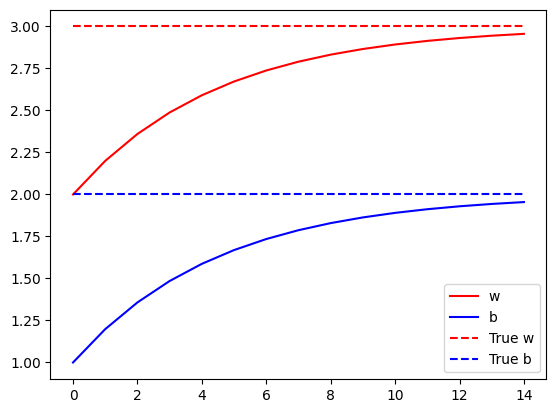

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epochs, list_w, 'r',
       epochs, list_b, 'b')
plt.plot([TRUE_w] * len(epochs), 'r--',
      [TRUE_b] * len(epochs), 'b--')
plt.legend(['w', 'b', 'True w', 'True b'])
plt.show()

**Plots for Evaluation**


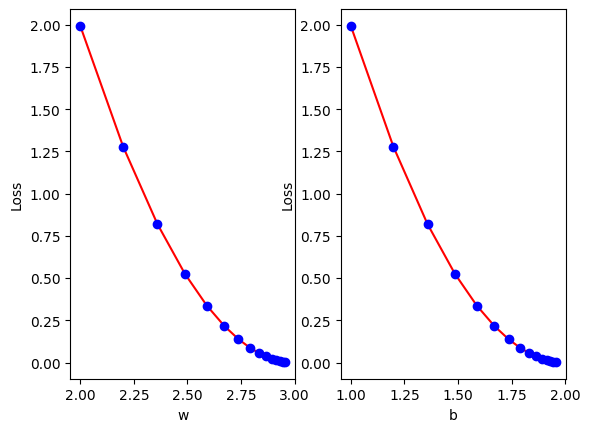

In [ ]:
def plot_loss_for_weights(weights_list, losses):
  for idx, weights in enumerate(weights_list):
    plt.subplot(120 + idx + 1)
    plt.plot(weights['values'], losses, 'r')
    plt.plot(weights['values'], losses, 'bo')
    plt.xlabel(weights['name'])
    plt.ylabel('Loss')


weights_list = [{ 'name' : "w",
                  'values' : list_w
                },
                {
                  'name' : "b",
                  'values' : list_b
                }]

plot_loss_for_weights(weights_list, losses)

#### Fashion MNIST using Custom Training Loop

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker



Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
# Load the Fashion MNIST dataset
(train_data, test_data), info = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)


In [ ]:
# Define a function to normalize and reshape the images
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    image = tf.reshape(image, [-1])  # Ensure the shape is flatten
    return image, label

# Apply the preprocess function to the training and test datasets
train_data = train_data.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data = test_data.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch and prefetch the datasets for performance optimization
#train_data = train_data.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
#test_data = test_data.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
batch_size = 32
train = train_data.shuffle(buffer_size=1024).batch(batch_size)
test =  test_data.batch(batch_size=batch_size)

**Define the Model**
You are using a simple model in this example. You use Keras Functional API to connect two dense layers. The final layer is a softmax that outputs one of the 10 classes since this is a multi class classification problem.

In [ ]:
def base_model():
  inputs = tf.keras.Input(shape=(784,), name='digits')
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

**Define Optimizer and Loss Function**

Chosen `adam` optimizer and sparse categorical crossentropy loss for this example.

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

**Define Metrics**

Define metrics so that training loop can update and display them. Here use `SparseCategoricalAccuracy`defined in `tf.keras.metrics` since the problem at hand is a multi class classification problem.

In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

**Building Training Loop**

In [ ]:
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)

  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  return logits, loss_value

This function performs training during one epoch.Run through all batches of training data in each epoch to make updates to trainable weights using the previous function. See that also call `update_state`  metrics to accumulate the value of the metrics.


In [ ]:
def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)

      losses.append(loss_value)

      train_acc_metric(y_batch_train, logits)
      pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
      pbar.update()
  return losses

At the end of each epoch have to validate the model on the test dataset. The following function calculates the loss on test dataset and updates the states of the validation metrics.

In [ ]:
def perform_validation():
  losses = []
  for x_val, y_val in test:
      val_logits = model(x_val)
      val_loss = loss_object(y_true=y_val, y_pred=val_logits)
      losses.append(val_loss)
      val_acc_metric(y_val, val_logits)
  return losses

Now combine the functions to establish the following flow:
1. Perform training over all batches of training data.
2. Get values of metrics.
3. Perform validation to calculate loss and update validation metrics on test data.
4. Reset the metrics at the end of epoch.
5. Display statistics at the end of each epoch.

In [ ]:
model = base_model()

# Iterate over epochs.
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  losses_val = perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))

  train_acc_metric.reset_states()
  val_acc_metric.reset_states()




Start of epoch 0


Training loss for step 1874: 0.3625: 100%|██████████| 1875/1875 



 Epoch 0: Train loss: 0.5052  Validation Loss: 0.4661, Train Accuracy: 0.8213, Validation Accuracy 0.8246
Start of epoch 1


Training loss for step 1874: 0.3816: 100%|██████████| 1875/1875 



 Epoch 1: Train loss: 0.3788  Validation Loss: 0.3819, Train Accuracy: 0.8627, Validation Accuracy 0.8611
Start of epoch 2


Training loss for step 1874: 0.3225: 100%|██████████| 1875/1875 



 Epoch 2: Train loss: 0.3427  Validation Loss: 0.3680, Train Accuracy: 0.8748, Validation Accuracy 0.8671
Start of epoch 3


Training loss for step 1874: 0.1102: 100%|██████████| 1875/1875 



 Epoch 3: Train loss: 0.3222  Validation Loss: 0.3656, Train Accuracy: 0.8821, Validation Accuracy 0.8706
Start of epoch 4


Training loss for step 1874: 0.6132: 100%|██████████| 1875/1875 



 Epoch 4: Train loss: 0.3066  Validation Loss: 0.3553, Train Accuracy: 0.8868, Validation Accuracy 0.8745
Start of epoch 5


Training loss for step 1874: 0.2095: 100%|██████████| 1875/1875 



 Epoch 5: Train loss: 0.2920  Validation Loss: 0.3600, Train Accuracy: 0.8925, Validation Accuracy 0.8711
Start of epoch 6


Training loss for step 1874: 0.3055: 100%|██████████| 1875/1875 



 Epoch 6: Train loss: 0.2797  Validation Loss: 0.3514, Train Accuracy: 0.8952, Validation Accuracy 0.8779
Start of epoch 7


Training loss for step 1874: 0.1319: 100%|██████████| 1875/1875 



 Epoch 7: Train loss: 0.2678  Validation Loss: 0.3792, Train Accuracy: 0.9003, Validation Accuracy 0.8641
Start of epoch 8


Training loss for step 1874: 0.3973: 100%|██████████| 1875/1875 



 Epoch 8: Train loss: 0.2574  Validation Loss: 0.3627, Train Accuracy: 0.9032, Validation Accuracy 0.8712
Start of epoch 9


Training loss for step 1874: 0.3616: 100%|██████████| 1875/1875 



 Epoch 9: Train loss: 0.2506  Validation Loss: 0.3642, Train Accuracy: 0.9054, Validation Accuracy 0.8727


## 2.4 Graph Mode

### 2.4.1 Introduction


TensorFlow provides two execution modes: Eager Mode and Graph Mode.

#### Eager Mode
Eager Mode is an imperative programming environment that evaluates operations immediately. This mode is intuitive and flexible, making it easy to debug and test models.



#### Graph Mode
Graph Mode (also known as TensorFlow 1.x mode) constructs a computational graph that defines the operations and dependencies. This graph is then executed by TensorFlow’s runtime, allowing for optimization and deployment.


#### **Simple Example**

Let's consider a simple linear regression problem.

**Eager Mode**

In [ ]:
import tensorflow as tf

# Enable Eager Execution
tf.config.run_functions_eagerly(True)

# Simple linear regression: y = 2x + 1
x = tf.constant(3.0)
w = tf.Variable(2.0)
b = tf.Variable(1.0)
y = w * x + b
print(y.numpy())  # Outputs: 7.0

7.0


**Graph Mode**

In [ ]:
import tensorflow as tf

# Disable Eager Execution
tf.compat.v1.disable_eager_execution()

# Simple linear regression: y = 2x + 1
x = tf.constant(3.0)
w = tf.Variable(2.0)
b = tf.Variable(1.0)
y = w * x + b

# Create and run session
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    result = sess.run(y)
    print(result)  # Outputs: 7.0

7.0



#### Feature Comparison Table

| Feature                      | Eager Mode                                  | Graph Mode                                    |
|------------------------------|---------------------------------------------|-----------------------------------------------|
| Execution Style              | Imperative, immediate evaluation            | Declarative, builds computational graphs      |
| Debugging                    | Easy to debug, similar to Python code       | More difficult to debug, requires sessions    |
| Performance                  | Generally slower due to immediate execution | Generally faster, optimizes computation graph |
| Flexibility                  | Highly flexible, easier for dynamic models  | Less flexible, better for static graphs       |
| Code Complexity              | Simpler and more intuitive                  | More boilerplate code, complex syntax         |
| Compatibility                | TensorFlow 2.x default mode                 | TensorFlow 1.x mode, requires compatibility imports in TF2.x |
| Use Cases                    | Prototyping, debugging, small-scale models  | Production deployment, large-scale models     |


### 2.4.2 Auto Graph Basics

Can use the `@tf.function` decorator to automatically generate the graph-style code as shown below:

In [ ]:
@tf.function
def add(a, b):
    return a + b


a = tf.Variable([[1.,2.],[3.,4.]])
b = tf.Variable([[4.,0.],[1.,5.]])
print(add(a, b))

# See what the generated code looks like
print(tf.autograph.to_code(add.python_function))

Tensor("add_1:0", shape=(2, 2), dtype=float32)
def tf__add(a, b):
    with ag__.FunctionScope('add', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        try:
            do_return = True
            retval_ = ag__.ld(a) + ag__.ld(b)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



**if-statements in autograph**
Control flow statements which are very intuitive to write in eager mode can look very complex in graph mode. See that in the next examples: first a simple function, then a more complicated one that involves lots of ops and conditionals (fizzbuzz).

In [ ]:
# simple function that returns the square if the input is greater than zero
@tf.function
def f(x):
    if x>0:
        x = x * x
    return x

print(tf.autograph.to_code(f.python_function))

def tf__f(x):
    with ag__.FunctionScope('f', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def if_body():
            nonlocal x
            x = ag__.ld(x) * ag__.ld(x)

        def else_body():
            nonlocal x
            pass
        ag__.if_stmt(ag__.ld(x) > 0, if_body, else_body, get_state, set_state, ('x',), 1)
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



**Example 1 :** Multiplication and addition

In [ ]:
a = tf.Variable(1.0)
b = tf.Variable(2.0)

@tf.function
def f(x,y):
    a.assign(y * b)
    b.assign_add(x * a)
    return a + b

print(f(1.0, 2.0))

print(tf.autograph.to_code(f.python_function))

Tensor("add_2:0", shape=(), dtype=float32)
def tf__f(x, y):
    with ag__.FunctionScope('f', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        ag__.converted_call(ag__.ld(a).assign, (ag__.ld(y) * ag__.ld(b),), None, fscope)
        ag__.converted_call(ag__.ld(b).assign_add, (ag__.ld(x) * ag__.ld(a),), None, fscope)
        try:
            do_return = True
            retval_ = ag__.ld(a) + ag__.ld(b)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



**Example 2  :** While Loops

In [ ]:
@tf.function
def f(x):
    while tf.reduce_sum(x) > 1:
        tf.print(x)
        x = tf.tanh(x)
    return x

print(tf.autograph.to_code(f.python_function))

def tf__f(x):
    with ag__.FunctionScope('f', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body():
            nonlocal x
            ag__.converted_call(ag__.ld(tf).print, (ag__.ld(x),), None, fscope)
            x = ag__.converted_call(ag__.ld(tf).tanh, (ag__.ld(x),), None, fscope)

        def loop_test():
            return ag__.converted_call(ag__.ld(tf).reduce_sum, (ag__.ld(x),), None, fscope) > 1
        ag__.while_stmt(loop_test, loop_body, get_state, set_state, ('x',), {})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



**Example 3 :** Print

In [ ]:
def f(x):
    print("Traced with", x)

for i in range(5):
    f(2)

f(3)

Traced with 2
Traced with 2
Traced with 2
Traced with 2
Traced with 2
Traced with 3


If you were to decorate this function with `@tf.function` and run it, notice that the print statement only appears once for `f(2)` even though it is called in a loop.

In [ ]:
@tf.function
def f(x):
    print("Traced with", x)

for i in range(5):
    f(2)

f(3)

Traced with 2
Traced with 2
Traced with 2
Traced with 2
Traced with 2
Traced with 3


Now compare `print` to `tf.print`.
- `tf.print` is graph aware and will run as expected in loops.

Try running the same code where `tf.print()` is added in addition to the regular `print`.
- Note how `tf.print` behaves compared to `print` in graph mode.

In [ ]:
@tf.function
def f(x):
    print("Traced with", x)
    # added tf.print
    tf.print("Executed with", x)

for i in range(5):
    f(2)

f(3)

Traced with 2
Traced with 2
Traced with 2
Traced with 2
Traced with 2
Traced with 3


#### Avoid defining variables inside the function

This function (not decorated yet) defines a tensor `v` and adds the input `x` to it.  

Here, it runs fine.

In [ ]:
def f(x):
    v = tf.Variable(1.0)
    v.assign_add(x)
    return v

print(f(1))

<tf.Variable 'Variable_6:0' shape=() dtype=float32>


In [ ]:
@tf.function
def f(x):
    v = tf.Variable(1.0)
    v.assign_add(x)
    return v

print(f(1))

<tf.Variable 'Variable_7:0' shape=() dtype=float32>


In [ ]:
# define the variables outside of the decorated function
v = tf.Variable(1.0)

@tf.function
def f(x):
    return v.assign_add(x)

print(f(5))

<tf.Variable 'AssignAddVariableOp_3' shape=() dtype=float32>


## 2.4 Distributed Training

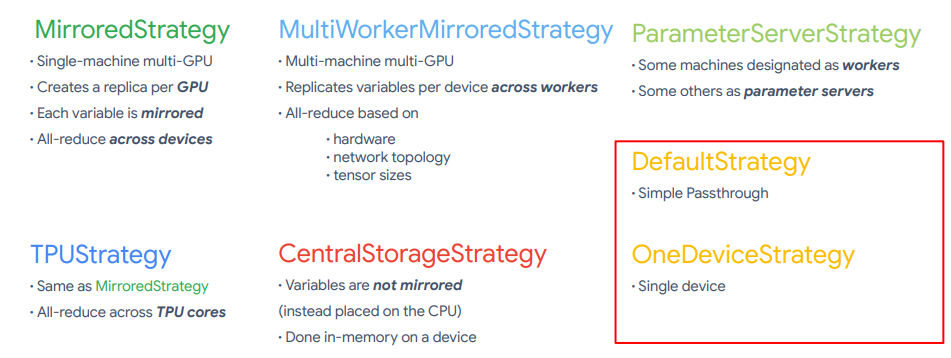

### 2.4.1 Mirrored Stratergy

In [ ]:
# Import TensorFlow and TensorFlow Datasets

import tensorflow_datasets as tfds
import tensorflow as tf
tfds.disable_progress_bar()

import os

Load the MNIST dataset and split it into training and test chunks.

In [ ]:
# Load the dataset we'll use for this lab
datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True, data_dir='./data')

mnist_train, mnist_test = datasets['train'], datasets['test']

Dataset mnist downloaded and prepared to ./data/mnist/3.0.1. Subsequent calls will reuse this data.


Next, you define `strategy` using the `MirroredStrategy()` class. Print to see the number of devices available.

In [ ]:
# Define the strategy to use and print the number of devices found
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


Next, create training and test examples, define batch size and also define `BATCH_SIZE_PER_REPLICA` which is the distribution making for each available device.

In [ ]:
# Get the number of examples in the train and test sets
num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples

BUFFER_SIZE = 10000

BATCH_SIZE_PER_REPLICA = 64
# Use for Mirrored Strategy
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
# Use for No Strategy
# BATCH_SIZE = BATCH_SIZE_PER_REPLICA * 1

A mapping function which normalizes images

In [ ]:
# Function for normalizing the image
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255

    return image, label

Next, create training and evaluation datesets in the batch size want by shuffling through buffer size.

In [ ]:
# Set up the train and eval data set
train_dataset = mnist_train.map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
eval_dataset = mnist_test.map(scale).batch(BATCH_SIZE)

For the model to follow the strategy, define model within the strategy's scope.
- Run all the cells below and notice the results.
- Afterwards comment out `with strategy.scope():` and run everything again, without the strategy.
Then compare the results.
> The important thing to notice and compare is the time taken for each epoch to complete. As mentioned in the lecture, doing a mirrored strategy on a single device (which our lab environment has) might take longer to train because of the overhead in implementing the strategy. With that, the advantages of using this strategy is more evident if use it on multiple devices.

In [ ]:
# Use for Mirrored Strategy -- comment out `with strategy.scope():` and deindent for no strategy
with strategy.scope():
    model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10)
    ])

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model.fit(train_dataset, epochs=12)

Epoch 1/12
938/938 [==============================] - 37s 35ms/step - loss: 0.1875 - accuracy: 0.9452
Epoch 2/12
938/938 [==============================] - 32s 34ms/step - loss: 0.0628 - accuracy: 0.9812
Epoch 3/12
938/938 [==============================] - 37s 40ms/step - loss: 0.0433 - accuracy: 0.9870
Epoch 4/12
938/938 [==============================] - 25s 27ms/step - loss: 0.0306 - accuracy: 0.9907
Epoch 5/12
938/938 [==============================] - 26s 27ms/step - loss: 0.0238 - accuracy: 0.9927
Epoch 6/12
938/938 [==============================] - 26s 28ms/step - loss: 0.0193 - accuracy: 0.9939
Epoch 7/12
938/938 [==============================] - 29s 31ms/step - loss: 0.0133 - accuracy: 0.9960
Epoch 8/12
938/938 [==============================] - 33s 36ms/step - loss: 0.0105 - accuracy: 0.9966
Epoch 9/12
938/938 [==============================] - 30s 32ms/step - loss: 0.0091 - accuracy: 0.9968
Epoch 10/12
938/938 [==============================] - 35s 37ms/step - loss: 0.005

### 2.4.2 Multi-GPU Mirrored Strategy

In [ ]:
import tensorflow as tf
import numpy as np
import os

Setup Distribution Strategy

In [ ]:
# Note that it generally has a minimum of 8 cores, but if your GPU has
# less, you need to set this. In this case one of my GPUs has 4 cores
os.environ["TF_MIN_GPU_MULTIPROCESSOR_COUNT"] = "4"

# If the list of devices is not specified in the
# `tf.distribute.MirroredStrategy` constructor, it will be auto-detected.
# If you have *different* GPUs in your system, you probably have to set up cross_device_ops like this
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


Prepare the Data

In [ ]:
# Get the data
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Adding a dimension to the array -> new shape == (28, 28, 1)
# We are doing this because the first layer in our model is a convolutional
# layer and it requires a 4D input (batch_size, height, width, channels).
# batch_size dimension will be added later on.
train_images = train_images[..., None]
test_images = test_images[..., None]

# Normalize the images to [0, 1] range.
train_images = train_images / np.float32(255)
test_images = test_images / np.float32(255)

# Batch the input data
BUFFER_SIZE = len(train_images)
BATCH_SIZE_PER_REPLICA = 64
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# Create Datasets from the batches
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(GLOBAL_BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(GLOBAL_BATCH_SIZE)

# Create Distributed Datasets from the datasets
train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
test_dist_dataset = strategy.experimental_distribute_dataset(test_dataset)

4422102/4422102 [==============================] - 0s 0us/step


Define the Model

In [ ]:
# Create the model architecture
def create_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10)
    ])
  return model

**Configure custom training**

Instead of `model.compile()`, we're going to do custom training, so let's do that within a strategy scope.

In [ ]:
with strategy.scope():
    # We will use sparse categorical crossentropy as always. But, instead of having the loss function
    # manage the map reduce across GPUs for us, we'll do it ourselves with a simple algorithm.
    # Remember -- the map reduce is how the losses get aggregated
    # Set reduction to `none` so we can do the reduction afterwards and divide byglobal batch size.
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

    def compute_loss(labels, predictions):
        # Compute Loss uses the loss object to compute the loss
        # Notice that per_example_loss will have an entry per GPU
        # so in this case there'll be 2 -- i.e. the loss for each replica
        per_example_loss = loss_object(labels, predictions)
        # You can print it to see it -- you'll get output like this:
        # Tensor("sparse_categorical_crossentropy/weighted_loss/Mul:0", shape=(48,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)
        # Tensor("replica_1/sparse_categorical_crossentropy/weighted_loss/Mul:0", shape=(48,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:1)
        # Note in particular that replica_0 isn't named in the weighted_loss -- the first is unnamed, the second is replica_1 etc
        print(per_example_loss)
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

    # We'll just reduce by getting the average of the losses
    test_loss = tf.keras.metrics.Mean(name='test_loss')

    # Accuracy on train and test will be SparseCategoricalAccuracy
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

    # Optimizer will be Adam
    optimizer = tf.keras.optimizers.Adam()

    # Create the model within the scope
    model = create_model()

**Train and Test Steps Functions**

In [ ]:
# `run` replicates the provided computation and runs it
# with the distributed input.
@tf.function
def distributed_train_step(dataset_inputs):
  per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
  #tf.print(per_replica_losses.values)
  return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

def train_step(inputs):
  images, labels = inputs
  with tf.GradientTape() as tape:
    predictions = model(images, training=True)
    loss = compute_loss(labels, predictions)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_accuracy.update_state(labels, predictions)
  return loss

#######################
# Test Steps Functions
#######################
@tf.function
def distributed_test_step(dataset_inputs):
  return strategy.run(test_step, args=(dataset_inputs,))

def test_step(inputs):
  images, labels = inputs

  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss.update_state(t_loss)
  test_accuracy.update_state(labels, predictions)




**Training Loop**

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
  # Do Training
  total_loss = 0.0
  num_batches = 0
  for batch in train_dist_dataset:
    total_loss += distributed_train_step(batch)
    num_batches += 1
  train_loss = total_loss / num_batches

  # Do Testing
  for batch in test_dist_dataset:
    distributed_test_step(batch)

  template = ("Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, " "Test Accuracy: {}")

  print (template.format(epoch+1, train_loss, train_accuracy.result()*100, test_loss.result(), test_accuracy.result()*100))

  test_loss.reset_states()
  train_accuracy.reset_states()
  test_accuracy.reset_states()

Tensor("sparse_categorical_crossentropy/weighted_loss/Mul:0", shape=(64,), dtype=float32, device=/job:localhost/replica:0/task:0/device:CPU:0)
Tensor("sparse_categorical_crossentropy/weighted_loss/Mul:0", shape=(64,), dtype=float32, device=/job:localhost/replica:0/task:0/device:CPU:0)
Tensor("sparse_categorical_crossentropy/weighted_loss/Mul:0", shape=(32,), dtype=float32, device=/job:localhost/replica:0/task:0/device:CPU:0)
Epoch 1, Loss: 0.5271821618080139, Accuracy: 81.01000213623047, Test Loss: 0.4070652425289154, Test Accuracy: 85.5999984741211
Epoch 2, Loss: 0.34527522325515747, Accuracy: 87.56333923339844, Test Loss: 0.34744101762771606, Test Accuracy: 87.1500015258789
Epoch 3, Loss: 0.2997215688228607, Accuracy: 89.06666564941406, Test Loss: 0.312747597694397, Test Accuracy: 88.95999908447266
Epoch 4, Loss: 0.2686658203601837, Accuracy: 90.09666442871094, Test Loss: 0.2960151135921478, Test Accuracy: 89.54000091552734
Epoch 5, Loss: 0.2464868128299713, Accuracy: 90.953330993652

### 2.4.3 TPU Strategy


**Imports**

In [ ]:
import os
import random
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print("TensorFlow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version 2.15.0


**Set up TPUs and initialize TPU Strategy**


In [ ]:
# Detect hardware
try:
  # Check if the environment variable exists before accessing it
  if 'COLAB_TPU_ADDR' in os.environ:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address) # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    # Going back and forth between TPU and host is expensive.
    # Better to run 128 batches on the TPU before reporting back.
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    print("Number of accelerators: ", strategy.num_replicas_in_sync)
  else:
    print('Not running on TPU. Using CPU/GPU instead.')
    # Add code here to configure your strategy for CPU/GPU usage
except ValueError:
  print('TPU failed to initialize.')

Not running on TPU. Using CPU/GPU instead.


**Download the Data from Google Cloud Storage**


In [ ]:
SIZE = 224 #@param ["192", "224", "331", "512"] {type:"raw"}
IMAGE_SIZE = [SIZE, SIZE]

In [ ]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-{}x{}/*.tfrec'.format(IMAGE_SIZE[0], IMAGE_SIZE[1])

BATCH_SIZE = 128  # On TPU in Keras, this is the per-core batch size. The global batch size is 8x this.

VALIDATION_SPLIT = 0.2
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
random.shuffle(filenames)

split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))

validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 128, there will be 23 batches per training epoch and 5 batch(es) per validation run.


**Create a dataset from the files**

- load_dataset takes the filenames and turns them into a tf.data.Dataset
- read_tfrecord parses out a tf record into the image, class and a one-hot-encoded version of the class
- Batch the data into training and validation sets with helper functions


In [ ]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = example['image']
    class_label = example['class']
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    class_label = tf.cast(class_label, tf.int32)
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
  # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.Dataset.from_tensor_slices(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO) # faster
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  dataset = dataset.shuffle(2048)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=False) # drop_remainder will be needed on TPU
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  return dataset

def get_training_dataset():
  dataset = get_batched_dataset(training_filenames)
  dataset = strategy.experimental_distribute_dataset(dataset)
  return dataset

def get_validation_dataset():
  dataset = get_batched_dataset(validation_filenames)
  dataset = strategy.experimental_distribute_dataset(dataset)
  return dataset

**Define the Model and training parameters**

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, classes):
    super(MyModel, self).__init__()
    self._conv1a = tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu')
    self._conv1b = tf.keras.layers.Conv2D(kernel_size=3, filters=30, padding='same', activation='relu')
    self._maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2)

    self._conv2a = tf.keras.layers.Conv2D(kernel_size=3, filters=60, padding='same', activation='relu')
    self._maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2)

    self._conv3a = tf.keras.layers.Conv2D(kernel_size=3, filters=90, padding='same', activation='relu')
    self._maxpool3 = tf.keras.layers.MaxPooling2D(pool_size=2)

    self._conv4a = tf.keras.layers.Conv2D(kernel_size=3, filters=110, padding='same', activation='relu')
    self._maxpool4 = tf.keras.layers.MaxPooling2D(pool_size=2)

    self._conv5a = tf.keras.layers.Conv2D(kernel_size=3, filters=130, padding='same', activation='relu')
    self._conv5b = tf.keras.layers.Conv2D(kernel_size=3, filters=40, padding='same', activation='relu')

    self._pooling = tf.keras.layers.GlobalAveragePooling2D()
    self._classifier = tf.keras.layers.Dense(classes, activation='softmax')

  def call(self, inputs):
    x = self._conv1a(inputs)
    x = self._conv1b(x)
    x = self._maxpool1(x)

    x = self._conv2a(x)
    x = self._maxpool2(x)

    x = self._conv3a(x)
    x = self._maxpool3(x)

    x = self._conv4a(x)
    x = self._maxpool4(x)

    x = self._conv5a(x)
    x = self._conv5b(x)

    x = self._pooling(x)
    x = self._classifier(x)
    return x

In [ ]:
import tensorflow as tf

# Define your strategy here, for example:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
  model = MyModel(classes=len(CLASSES))
  # Set reduction to `none` so we can do the reduction afterwards and divide by
  # global batch size.
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      reduction=tf.keras.losses.Reduction.NONE)

  def compute_loss(labels, predictions):
    per_example_loss = loss_object(labels, predictions)
    return tf.nn.compute_average_loss(per_example_loss, global_batch_size=BATCH_SIZE * strategy.num_replicas_in_sync)

  test_loss = tf.keras.metrics.Mean(name='test_loss')

  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='train_accuracy')
  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='test_accuracy')

  optimizer = tf.keras.optimizers.Adam()

  @tf.function
  def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step,args=(dataset_inputs,))
    print(per_replica_losses)
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                           axis=None)

  @tf.function
  def distributed_test_step(dataset_inputs):
    strategy.run(test_step, args=(dataset_inputs,))


  def train_step(inputs):
    images, labels = inputs

    with tf.GradientTape() as tape:
      predictions = model(images)
      loss = compute_loss(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_accuracy.update_state(labels, predictions)

    return loss

  def test_step(inputs):
    images, labels = inputs

    predictions = model(images)
    loss = loss_object(labels, predictions)

    test_loss.update_state(loss)
    test_accuracy.update_state(labels, predictions)


In [ ]:
EPOCHS = 40
with strategy.scope():
  for epoch in range(EPOCHS):
    # TRAINING LOOP
    total_loss = 0.0
    num_batches = 0
    for x in get_training_dataset():
      total_loss += distributed_train_step(x)
      num_batches += 1
    train_loss = total_loss / num_batches

    # TESTING LOOP
    for x in get_validation_dataset():
      distributed_test_step(x)

    template = ("Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Test Loss: {:.2f}, "
                "Test Accuracy: {:.2f}")
    print (template.format(epoch+1, train_loss,
                           train_accuracy.result()*100, test_loss.result() / strategy.num_replicas_in_sync,
                           test_accuracy.result()*100))

    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()

Tensor("div_no_nan:0", shape=(), dtype=float32, device=/job:localhost/replica:0/task:0/device:CPU:0)
Tensor("div_no_nan:0", shape=(), dtype=float32, device=/job:localhost/replica:0/task:0/device:CPU:0)
Tensor("div_no_nan:0", shape=(), dtype=float32, device=/job:localhost/replica:0/task:0/device:CPU:0)
Epoch 1, Loss: 1.45, Accuracy: 30.23, Test Loss: 1.35, Test Accuracy: 36.09
Epoch 2, Loss: 1.20, Accuracy: 47.52, Test Loss: 1.19, Test Accuracy: 47.39
Epoch 3, Loss: 1.09, Accuracy: 50.97, Test Loss: 1.15, Test Accuracy: 52.61
Epoch 4, Loss: 1.05, Accuracy: 56.74, Test Loss: 1.08, Test Accuracy: 54.35
Epoch 5, Loss: 0.98, Accuracy: 58.46, Test Loss: 1.00, Test Accuracy: 61.59
Epoch 6, Loss: 0.97, Accuracy: 59.36, Test Loss: 1.01, Test Accuracy: 58.55
Epoch 7, Loss: 0.94, Accuracy: 60.97, Test Loss: 1.01, Test Accuracy: 60.14
Epoch 8, Loss: 0.89, Accuracy: 63.86, Test Loss: 1.03, Test Accuracy: 59.13
Epoch 9, Loss: 0.88, Accuracy: 62.79, Test Loss: 0.95, Test Accuracy: 61.45
Epoch 10, Los

**Predictions**

In [ ]:
#@title display utilities [RUN ME]
import matplotlib.pyplot as plt

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)

  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;

  else: # In non-eager mode, must get the TF note that
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels = ses.run(get_next_item)

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  # one-hot to class number
  # correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[np.argmax(labels[i], axis=-1)]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

In [ ]:
inference_model = model

In [ ]:
some_flowers, some_labels = dataset_to_numpy_util(load_dataset(validation_filenames), 8*20)

['daisy', 'sunflowers', 'dandelion', 'roses', 'tulips', 'sunflowers', 'dandelion', 'sunflowers', 'roses', 'tulips', 'roses', 'dandelion', 'roses', 'dandelion', 'sunflowers', 'dandelion', 'roses', 'sunflowers', 'daisy', 'roses', 'tulips', 'dandelion', 'daisy', 'roses', 'tulips', 'roses', 'tulips', 'sunflowers', 'sunflowers', 'dandelion', 'daisy', 'dandelion', 'dandelion', 'sunflowers', 'dandelion', 'sunflowers', 'tulips', 'dandelion', 'daisy', 'dandelion', 'dandelion', 'tulips', 'dandelion', 'roses', 'dandelion', 'roses', 'tulips', 'dandelion', 'sunflowers', 'tulips', 'sunflowers', 'sunflowers', 'dandelion', 'daisy', 'roses', 'tulips', 'tulips', 'tulips', 'sunflowers', 'daisy', 'tulips', 'sunflowers', 'tulips', 'daisy', 'daisy', 'sunflowers', 'roses', 'dandelion', 'roses', 'daisy', 'dandelion', 'tulips', 'dandelion', 'sunflowers', 'daisy', 'daisy', 'daisy', 'daisy', 'tulips', 'sunflowers', 'tulips', 'dandelion', 'sunflowers', 'roses', 'sunflowers', 'tulips', 'daisy', 'tulips', 'roses', 

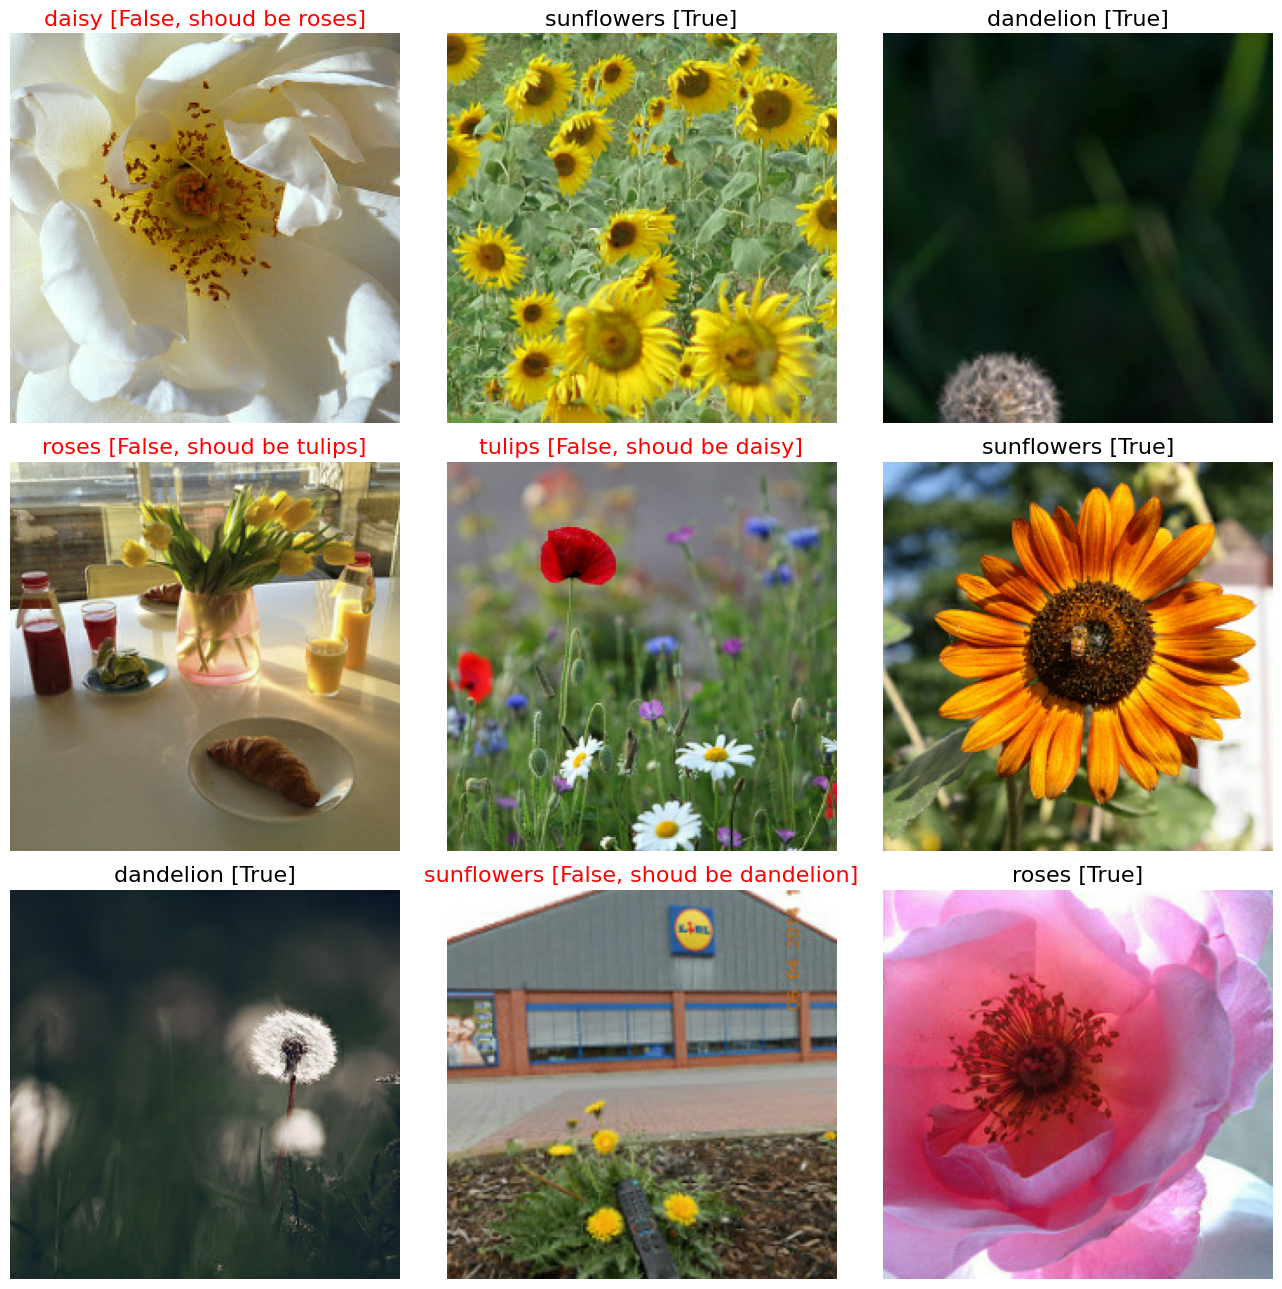

In [ ]:
import numpy as np
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(8*20)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = inference_model(some_flowers)

print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

display_9_images_with_predictions(some_flowers, predictions, some_labels)

### 2.4.4  One Device Strategy

In this ungraded lab, you'll learn how to set up a [One Device Strategy](https://www.tensorflow.org/api_docs/python/tf/distribute/OneDeviceStrategy). This is typically used to deliberately test your code on a single device. This can be used before switching to a different strategy that distributes across multiple devices. Please click on the **Open in Colab** badge above so you can download the datasets and use a GPU-enabled lab environment.

**Imports**

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


**Define the Distribution Strategy**

You can list available devices in your machine and specify a device type. This allows you to verify the device name to pass in `tf.distribute.OneDeviceStrategy()`.

In [ ]:
# choose a device type such as CPU or GPU
devices = tf.config.list_physical_devices('GPU')
print(devices[0])

# You'll see that the name will look something like "/physical_device:GPU:0"
# Just take the GPU:0 part and use that as the name
gpu_name = "GPU:0"

# define the strategy and pass in the device name
one_strategy = tf.distribute.OneDeviceStrategy(device=gpu_name)

IndexError: list index out of range

**Parameters**

We'll define a few global variables for setting up the model and dataset.

In [ ]:
pixels = 224
MODULE_HANDLE = 'https://tfhub.dev/tensorflow/resnet_50/feature_vector/1'
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 32

print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

**Download and Prepare the Dataset**

We will use the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset and we will fetch it via TFDS.

In [ ]:
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

(train_examples, validation_examples, test_examples), info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split=splits)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [ ]:
# resize the image and normalize pixel values
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, label

In [ ]:
# prepare batches
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

In [ ]:
# check if the batches have the correct size and the images have the correct shape
for image_batch, label_batch in train_batches.take(1):
    pass

print(image_batch.shape)

**Define and Configure the Model**

As with other strategies, setting up the model requires minimal code changes. Let's first define a utility function to build and compile the model.

In [ ]:
# tells if we want to freeze the layer weights of our feature extractor during training
do_fine_tuning = False

In [ ]:
def build_and_compile_model():
    print("Building model with", MODULE_HANDLE)

    # configures the feature extractor fetched from TF Hub
    feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   trainable=do_fine_tuning)

    # define the model
    model = tf.keras.Sequential([
      feature_extractor,
      # append a dense with softmax for the number of classes
      tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # display summary
    model.summary()

    # configure the optimizer, loss and metrics
    optimizer = tf.keras.optimizers.SGD(lr=0.002, momentum=0.9) if do_fine_tuning else 'adam'
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return model

You can now call the function under the strategy scope. This places variables and computations on the device you specified earlier.

In [ ]:
# build and compile under the strategy scope
with one_strategy.scope():
    model = build_and_compile_model()

`model.fit()` can be run as usual.

In [ ]:
EPOCHS = 5
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)